**Team Members:**
1. Raj Kumar Mannam - 1002126524
2. Manisha Varma Bharatha - 1002034501
3. Balaji Bonagiri - 1002069262

# Part A: Fully Connected Network from scratch

In [1]:
# Import necessary libraries
import numpy as np
import torch
import torchvision

# Loading and Normalizing the CIFAR10 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Convert the images to flattened numpy arrays
train_images = np.array([np.array(img[0].numpy()).flatten() for img in trainset])
train_labels = np.array([img[1] for img in trainset])

test_images = np.array([np.array(img[0].numpy()).flatten() for img in testset])
test_labels = np.array([img[1] for img in testset])

# Shuffle the dataset
p = np.random.permutation(len(train_images))
train_images, train_labels = train_images[p], train_labels[p]

# Split the dataset into training and validation sets
val_size = int(0.1 * len(train_images))
val_images, val_labels = train_images[:val_size], train_labels[:val_size]
train_images, train_labels = train_images[val_size:], train_labels[val_size:]

print("Training Images Shape:", train_images.shape)
print("Validation Images Shape:", val_images.shape)
print("Test Images Shape:", test_images.shape)


100%|██████████| 170498071/170498071 [00:03<00:00, 44757018.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training Images Shape: (45000, 3072)
Validation Images Shape: (5000, 3072)
Test Images Shape: (10000, 3072)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork:
    def __init__(self, layer_dimensions):
        self.parameters = {}
        self.L = len(layer_dimensions)
        self.v = {}
        self.s = {}
        for l in range(1, self.L):
            self.parameters["W" + str(l)] = np.random.randn(layer_dimensions[l], layer_dimensions[l-1]) * np.sqrt(2. / layer_dimensions[l-1])  # He initialization
            self.parameters["b" + str(l)] = np.zeros((layer_dimensions[l], 1))
            self.v["dW" + str(l)] = np.zeros((layer_dimensions[l], layer_dimensions[l-1]))
            self.v["db" + str(l)] = np.zeros((layer_dimensions[l], 1))
            self.s["dW" + str(l)] = np.zeros((layer_dimensions[l], layer_dimensions[l-1]))
            self.s["db" + str(l)] = np.zeros((layer_dimensions[l], 1))

    def affineForward(self, A, W, b):
        Z = np.dot(W, A) + b
        cache = (A, W, b)
        return Z, cache

    def activationForward(self, A):
        return np.maximum(0, A), A

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))  # for numerical stability
        return expZ / np.sum(expZ, axis=0, keepdims=True)

    def forwardPropagation(self, X):
        caches = []
        A = X.T
        for l in range(1, self.L - 1):  # Keep the last layer for softmax
            Z, affine_cache = self.affineForward(A, self.parameters["W"+str(l)], self.parameters["b"+str(l)])
            A, activation_cache = self.activationForward(Z)
            caches.append((affine_cache, activation_cache))

        # Softmax for the last layer
        ZL, affine_cache = self.affineForward(A, self.parameters["W" + str(self.L-1)], self.parameters["b" + str(self.L-1)])
        AL = self.softmax(ZL)
        caches.append((affine_cache, ZL))

        return AL, caches

    def costFunction(self, AL, y, lambd=0.7):  # Added L2 regularization
        m = y.shape[1]
        corect_logprobs = -np.log(AL[y.argmax(axis=0), range(m)])
        cross_entropy_cost = np.sum(corect_logprobs) / m

        L2_regularization_cost = (lambd / (2 * m)) * sum([np.sum(np.square(self.parameters["W" + str(l)])) for l in range(1, self.L)])

        return cross_entropy_cost + L2_regularization_cost



    def affineBackward(self, dA_prev, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = np.dot(dA_prev, A_prev.T) / m
        db = np.sum(dA_prev, axis=1, keepdims=True) / m
        dA = np.dot(W.T, dA_prev)
        return dA, dW, db

    def activationBackward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        return dZ

    def backPropagation(self, dAL, Y, cache, lambd=0.7):
        gradients = {}
        m = Y.shape[1]

        current_cache = cache[-1]
        affine_cache, ZL = current_cache

        # Softmax gradient
        dZL = dAL - Y

        dA_prev, dW, db = self.affineBackward(dZL, affine_cache)
        gradients["dW" + str(self.L-1)] = dW + (lambd / m) * self.parameters["W" + str(self.L-1)]
        gradients["db" + str(self.L-1)] = db

        dA = dA_prev

        for l in reversed(range(1, self.L-1)):
            current_cache = cache[l-1]
            affine_cache, activation_cache = current_cache
            dZ = self.activationBackward(dA, activation_cache)
            dA, dW, db = self.affineBackward(dZ, affine_cache)
            gradients["dW" + str(l)] = dW + (lambd / m) * self.parameters["W" + str(l)]
            gradients["db" + str(l)] = db
        return gradients


    def updateParameters(self, gradients, alpha, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """ Update the parameters using Adam optimization algorithm """
        for l in range(1, self.L):
            self.v["dW" + str(l)] = beta1 * self.v["dW" + str(l)] + (1 - beta1) * gradients["dW" + str(l)]
            self.v["db" + str(l)] = beta1 * self.v["db" + str(l)] + (1 - beta1) * gradients["db" + str(l)]

            v_corr_w = self.v["dW" + str(l)] / (1 - np.power(beta1, t))
            v_corr_b = self.v["db" + str(l)] / (1 - np.power(beta1, t))

            self.s["dW" + str(l)] = beta2 * self.s["dW" + str(l)] + (1 - beta2) * np.square(gradients["dW" + str(l)])
            self.s["db" + str(l)] = beta2 * self.s["db" + str(l)] + (1 - beta2) * np.square(gradients["db" + str(l)])

            s_corr_w = self.s["dW" + str(l)] / (1 - np.power(beta2, t))
            s_corr_b = self.s["db" + str(l)] / (1 - np.power(beta2, t))

            self.parameters["W" + str(l)] -= alpha * v_corr_w / (np.sqrt(s_corr_w) + epsilon)
            self.parameters["b" + str(l)] -= alpha * v_corr_b / (np.sqrt(s_corr_b) + epsilon)

    def train(self, X_train, X_val, y_train, y_val, iters, alpha, batch_size):
        m = X_train.shape[0]
        costs = []
        t = 0  # for Adam optimization

        for i in range(0, iters):
            permutation = np.random.permutation(m)
            X_shuffled = X_train[permutation]
            y_shuffled = y_train[permutation]

            for j in range(0, m, batch_size):
                t += 1  # Increment Adam iteration
                X_mini_batch = X_shuffled[j:j+batch_size]
                y_mini_batch = y_shuffled[j:j+batch_size]

                AL, caches = self.forwardPropagation(X_mini_batch)
                gradients = self.backPropagation(AL, y_mini_batch.T, caches)
                self.updateParameters(gradients, alpha, t)

            if i % 5 == 0:
                AL, _ = self.forwardPropagation(X_train)
                cost = self.costFunction(AL, y_train.T)
                costs.append(cost)
                AL_train, _ = self.forwardPropagation(X_train)
                predictions_train = np.argmax(AL_train, axis=0)
                labels_train = np.argmax(y_train, axis=1)
                accuracy_train = np.mean(predictions_train == labels_train) * 100
                AL_val, _ = self.forwardPropagation(X_val)
                predictions_val = np.argmax(AL_val, axis=0)
                labels_val = np.argmax(y_val, axis=1)
                accuracy_val = np.mean(predictions_val == labels_val) * 100
                print(f'Iteration {i} | Cost: {cost:.4f} | Training Accuracy: {accuracy_train:.2f}% | Validation Accuracy: {accuracy_val:.2f}%')

        plt.plot(costs)
        plt.xlabel('Iterations (per hundreds)')
        plt.ylabel('Cost')
        plt.title(f'Learning Rate: {alpha}')
        plt.show()

    def predict(self, X_new):
        AL, _ = self.forwardPropagation(X_new)
        predictions = np.argmax(AL, axis=0)
        return predictions



Iteration 0 | Cost: 1.5390 | Training Accuracy: 46.65% | Validation Accuracy: 44.06%
Iteration 5 | Cost: 1.3274 | Training Accuracy: 53.76% | Validation Accuracy: 47.34%
Iteration 10 | Cost: 1.2460 | Training Accuracy: 56.82% | Validation Accuracy: 49.68%
Iteration 15 | Cost: 1.2275 | Training Accuracy: 57.04% | Validation Accuracy: 51.30%
Iteration 20 | Cost: 1.1997 | Training Accuracy: 58.01% | Validation Accuracy: 50.36%
Iteration 25 | Cost: 1.1938 | Training Accuracy: 58.27% | Validation Accuracy: 50.26%
Iteration 30 | Cost: 1.1717 | Training Accuracy: 59.15% | Validation Accuracy: 51.56%
Iteration 35 | Cost: 1.1588 | Training Accuracy: 59.90% | Validation Accuracy: 51.68%
Iteration 40 | Cost: 1.1432 | Training Accuracy: 60.50% | Validation Accuracy: 51.68%
Iteration 45 | Cost: 1.1439 | Training Accuracy: 60.32% | Validation Accuracy: 51.60%


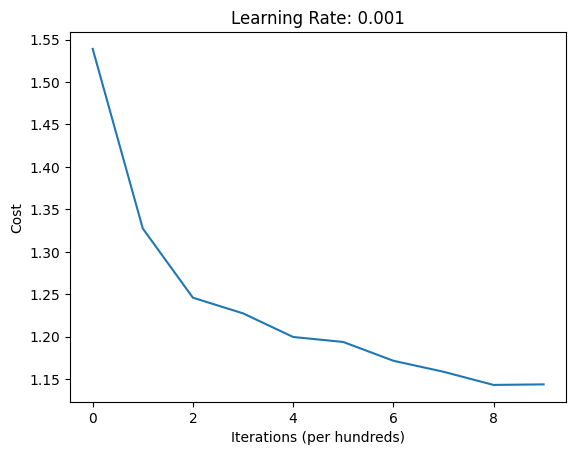

In [4]:
# Convert integer labels to one-hot encoded labels
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

# Preprocess the CIFAR-10 dataset
num_classes = 10
y_train_one_hot = one_hot_encode(train_labels, num_classes)
y_val_one_hot = one_hot_encode(val_labels, num_classes)
y_test_one_hot = one_hot_encode(test_labels, num_classes)

# Initialize the neural network
layer_dimensions = [3072, 64, 10]  # e.g., for CIFAR10 where input is 32x32x3=3072, and output is 10 classes
nn = NeuralNetwork(layer_dimensions)

# Train the neural network
alpha = 0.001
batch_size = 256
iters = 50
nn.train(train_images, val_images, y_train_one_hot, y_val_one_hot, iters, alpha, batch_size)


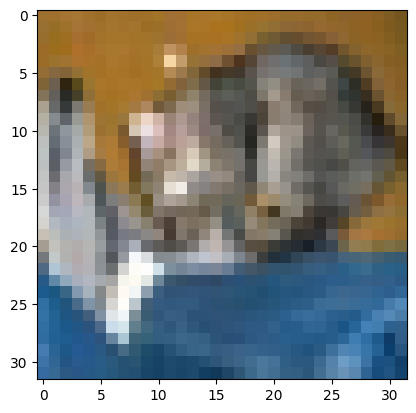

Predicted Label: cat


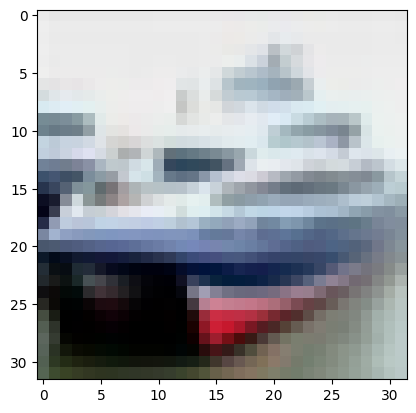

Predicted Label: truck


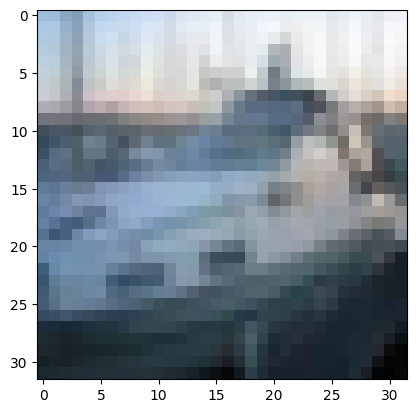

Predicted Label: airplane


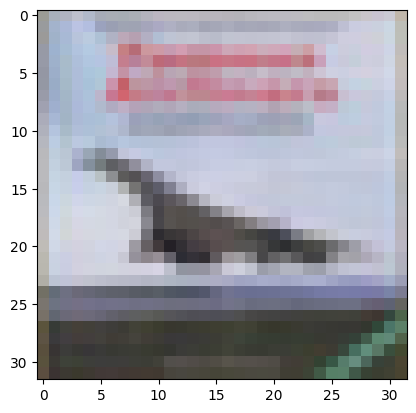

Predicted Label: airplane


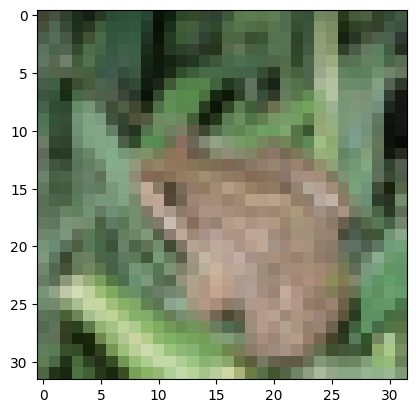

Predicted Label: frog


In [5]:
import numpy as np
import matplotlib.pyplot as plt

CIFAR10_LABELS_LIST = [
    'ship',
    'automobile',
    'bird',
    'cat',
    'frog',
    'dog',
    'deer',
    'horse',
    'airplane',
    'truck'
]

def index_to_label(index):
    return CIFAR10_LABELS_LIST[index]


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

def display_images_predictions(testset, model, num_images=5):
    for i in range(num_images):
        image, _ = testset[i]
        imshow(image.numpy())

        # Reshape and expand dimensions to form a batch
        image_batch = np.expand_dims(image.numpy().reshape(-1), axis=0)

        output = model.predict(image_batch)
        predicted_label = index_to_label(output[0])
        print(f"Predicted Label: {predicted_label}")


# Assume `nn_model` is your trained model and `testset` is your test dataset.
display_images_predictions(testset, nn, num_images=5)


# Part 2: CNN using PyTorch

In [6]:
# 1.6 Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


In [7]:
# 1.7 Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate the model and move it to GPU
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

print("Training Complete!")

# 1.8 Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Validation Accuracy: {100 * correct / total}%")


Epoch 1, Loss: 1.4505625278202456
Epoch 2, Loss: 1.1088512489028068
Epoch 3, Loss: 0.9715462690901061
Epoch 4, Loss: 0.8791640453204757
Epoch 5, Loss: 0.8038246474032209
Epoch 6, Loss: 0.7378831523779698
Epoch 7, Loss: 0.676506668604598
Epoch 8, Loss: 0.6202920242434456
Epoch 9, Loss: 0.5706097674056326
Epoch 10, Loss: 0.5215764295127092
Epoch 11, Loss: 0.47053066750706385
Epoch 12, Loss: 0.42722529491148864
Epoch 13, Loss: 0.38304346835858955
Epoch 14, Loss: 0.3467653592798247
Epoch 15, Loss: 0.30598740202891717
Epoch 16, Loss: 0.2736318622687309
Epoch 17, Loss: 0.2421888051701507
Epoch 18, Loss: 0.21500269857625123
Epoch 19, Loss: 0.19203193531144613
Epoch 20, Loss: 0.17223176751193123
Training Complete!
Validation Accuracy: 73.42%


Data Augmentation:
We will add random horizontal flips and random crops to the training data to augment the dataset.


Modify Architecture:
Add an extra convolutional layer, change kernel sizes, and add an extra fully connected layer.

In [8]:
# 1.7 Modify the CNN architecture
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Instantiate the model and move it to GPU
model = ModifiedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

print("Training Complete!")

# 1.8 Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Validation Accuracy: {100 * correct / total}%")

Epoch 1, Loss: 1.5645852246941958
Epoch 2, Loss: 1.1467011579403068
Epoch 3, Loss: 0.9784451680312194
Epoch 4, Loss: 0.868001042102022
Epoch 5, Loss: 0.7811722798642319
Epoch 6, Loss: 0.7193610049259942
Epoch 7, Loss: 0.6610402180611367
Epoch 8, Loss: 0.613444112426606
Epoch 9, Loss: 0.5680198795039686
Epoch 10, Loss: 0.5237981103990802
Epoch 11, Loss: 0.4839376960090059
Epoch 12, Loss: 0.44906164939808524
Epoch 13, Loss: 0.41461955388980126
Epoch 14, Loss: 0.38828616775969454
Epoch 15, Loss: 0.35041788765828324
Epoch 16, Loss: 0.3241129125618689
Epoch 17, Loss: 0.2968616408071538
Epoch 18, Loss: 0.2678908757076419
Epoch 19, Loss: 0.24952730656400926
Epoch 20, Loss: 0.22408577917486577
Training Complete!
Validation Accuracy: 77.44%
